# Sample Analysis of OKCupid Data

All this in Python 2.7.

By Jonathan Lu

3/26/2019

Updated 4/10/2019

This notebook at http://tinyurl.com/cos424-s2019-4-10

* Discuss assignment 3 expectations: https://piazza.com/class/jrjbaqaa7ql3zs?cid=254

* LDA resources:

http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/


https://docs.google.com/presentation/d/1TLUlrVuotmLy5oSsfldnbNYZqyJLfgZKniyWmw1qAxQ/edit#slide=id.g57caf0041a_0_19


* What do components mean?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# increase the width of the pandas dataframe to allow scrolling through all columns

pd.options.display.max_columns = 100

In [2]:
profile_df = pd.read_csv("profiles.csv")

In [3]:
print profile_df.shape[0], ""
print profile_df.shape[1], "Columns"
profile_df.head()

59946 
31 Columns


,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


How sparse is this?

In [4]:
print "# non-null entries:", profile_df.notnull().sum().sum()
print "# Total entries: ", profile_df.shape[0] * profile_df.shape[1]

print "Proportion non-null entries: ", profile_df.notnull().sum().sum() * 1.0 / (profile_df.shape[0] * profile_df.shape[1])

# non-null entries: 1585144
# Total entries:  1858326
Proportion non-null entries:  0.852995653077


In [5]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
age            59946 non-null int64
body_type      54650 non-null object
diet           35551 non-null object
drinks         56961 non-null object
drugs          45866 non-null object
education      53318 non-null object
essay0         54461 non-null object
essay1         52375 non-null object
essay2         50308 non-null object
essay3         48470 non-null object
essay4         49409 non-null object
essay5         49099 non-null object
essay6         46175 non-null object
essay7         47496 non-null object
essay8         40732 non-null object
essay9         47344 non-null object
ethnicity      54266 non-null object
height         59943 non-null float64
income         59946 non-null int64
job            51748 non-null object
last_online    59946 non-null object
location       59946 non-null object
offspring      24385 non-null object
orientation    59946 non-null object
pets

Let's take a look at the distribution of variables in each column.

In [6]:
profile_df.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


Looks like the only numerical variables are age, height, income.

What are my columns?

See okcupid_codebook.txt for more detail.

Why are there -1s in income? They indicate "rather not say". Let's remove it for now

In [7]:
print "Before shape", profile_df.shape

profile_df = profile_df[profile_df['income'] != -1]

print "After shape", profile_df.shape

Before shape (59946, 31)
After shape (11504, 31)


Many of these are categorical data. Let's use one-hot encoding.

In [8]:
categorical_columns = ['body_type',
                      'diet',
                      'drinks',
                      'drugs',
                      'education',
                      'ethnicity',
                      'job',
                      'offspring',
                      'orientation',
                      'pets',
                      'religion',
                       'sex',
                       'sign',
                       'smokes',
                       'speaks',
                       'status']
profile_num_df = pd.get_dummies(profile_df, 
                                columns = categorical_columns)
print profile_num_df.shape
profile_num_df

(11504, 2639)


,age,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,height,income,last_online,location,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,...,"speaks_english, spanish (poorly), russian (okay)","speaks_english, spanish (poorly), sign language (poorly)","speaks_english, spanish (poorly), tagalog (fluently)","speaks_english, spanish, arabic","speaks_english, spanish, c++","speaks_english, spanish, czech","speaks_english, spanish, estonian","speaks_english, spanish, french","speaks_english, spanish, french, russian","speaks_english, spanish, german","speaks_english, spanish, german, french, polish","speaks_english, spanish, irish","speaks_english, spanish, italian","speaks_english, spanish, italian (poorly)","speaks_english, spanish, latin, french","speaks_english, spanish, other","speaks_english, spanish, portuguese (poorly)","speaks_english, spanish, portuguese, french (okay)","speaks_english, spanish, portuguese, italian","speaks_english, spanish, sign language","speaks_english, spanish, tagalog","speaks_english, spanish, yiddish, c++, farsi","speaks_english, swahili (poorly)","speaks_english, swedish (fluently)","speaks_english, swedish (poorly)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog (okay)","speaks_english, tagalog (okay), spanish (poorly)","speaks_english, tagalog (poorly)","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, tamil, c++","speaks_english, thai","speaks_english, thai (poorly)","speaks_english, turkish","speaks_english, urdu, c++, cebuano","speaks_english, vietnamese","speaks_english, vietnamese (fluently), khmer (poorly)","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, vietnamese (okay)","speaks_english, yiddish","speaks_english, yiddish (fluently), tagalog (fluently), sanskrit (fluently), lisp (fluently)","speaks_english, yiddish (poorly)",status_available,status_married,status_seeing someone,status_single,status_unknown
1,35,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,70.0,80000,2012-06-29-21-41,"oakland, california",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,23,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,71.0,20000,2012-06-28-14-22,"berkeley, california",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,28,"i was born in wisconsin, grew up in iowa, and ...",i'm currently the youngest member on an intern...,i'm really good at a little bit of everything....,"the way i dress. some days it's hats, other da...",books = yes. avid reader.<br />\nmoves = etern...,"guitar - even if i don't play it all the

In [9]:
# Get the columns that are only numerical

print np.unique(profile_num_df.dtypes)


[dtype('uint8') dtype('int64') dtype('float64') dtype('O')]


In [10]:

print "Original augmented columns: ", profile_num_df.shape[1]


sub_columns = [c for c in profile_num_df.columns.values if 
              (profile_num_df[c].dtype == np.uint8) or 
               (profile_num_df[c].dtype == np.int64) or
               (profile_num_df[c].dtype == np.float64)]

profile_num_df = profile_num_df[sub_columns]
print "Subset to only numerical columns: ", profile_num_df.shape[1]

profile_num_df

Original augmented columns:  2639
Subset to only numerical columns:  2627


,age,height,income,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,drugs_never,drugs_often,drugs_sometimes,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,...,"speaks_english, spanish (poorly), russian (okay)","speaks_english, spanish (poorly), sign language (poorly)","speaks_english, spanish (poorly), tagalog (fluently)","speaks_english, spanish, arabic","speaks_english, spanish, c++","speaks_english, spanish, czech","speaks_english, spanish, estonian","speaks_english, spanish, french","speaks_english, spanish, french, russian","speaks_english, spanish, german","speaks_english, spanish, german, french, polish","speaks_english, spanish, irish","speaks_english, spanish, italian","speaks_english, spanish, italian (poorly)","speaks_english, spanish, latin, french","speaks_english, spanish, other","speaks_english, spanish, portuguese (poorly)","speaks_english, spanish, portuguese, french (okay)","speaks_english, spanish, portuguese, italian","speaks_english, spanish, sign language","speaks_english, spanish, tagalog","speaks_english, spanish, yiddish, c++, farsi","speaks_english, swahili (poorly)","speaks_english, swedish (fluently)","speaks_english, swedish (poorly)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog (okay)","speaks_english, tagalog (okay), spanish (poorly)","speaks_english, tagalog (poorly)","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, tamil, c++","speaks_english, thai","speaks_english, thai (poorly)","speaks_english, turkish","speaks_english, urdu, c++, cebuano","speaks_english, vietnamese","speaks_english, vietnamese (fluently), khmer (poorly)","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, vietnamese (okay)","speaks_english, yiddish","speaks_english, yiddish (fluently), tagalog (fluently), sanskrit (fluently), lisp (fluently)","speaks_english, yiddish (poorly)",status_available,status_married,status_seeing someone,status_single,status_unknown
1,35,70.0,80000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,23,71.0,20000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,28,72.0,40000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13,30,66.0,30000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,29,62.0,50000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
43,40,71.0,60000,0,0

# Some basic analysis

In [11]:
print "Relationship statuses:"
print np.unique(profile_df['status'].values)

print profile_df['status'].describe()
print profile_df['status'].value_counts()


Relationship statuses:
['available' 'married' 'seeing someone' 'single' 'unknown']
count      11504
unique         5
top       single
freq       10465
Name: status, dtype: object
single            10465
seeing someone      483
available           468
married              86
unknown               2
Name: status, dtype: int64


If you didn't want to type into latex:

In [12]:
print profile_df['status'].value_counts().to_latex()

\begin{tabular}{lr}
\toprule
{} &  status \\
\midrule
single         &   10465 \\
seeing someone &     483 \\
available      &     468 \\
married        &      86 \\
unknown        &       2 \\
\bottomrule
\end{tabular}



In [13]:
# Let's figure out how many folks of each type there are

profile_df.groupby('status').count()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks
status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
available,468,427,279,465,388,440,435,420,422,403,408,406,398,389,369,413,427,468,468,455,468,468,233,468,375,388,468,409,452,467
married,86,75,48,86,72,84,76,71,64,62,66,63,61,62,59,60,76,86,86,83,86,86,47,86,69,78,86,81,84,86
seeing someone,483,427,260,478,409,453,458,449,440,433,425,429,418,422,394,429,447,483,483,475,483,483,169,483,408,407,483,445,468,483
single,10465,10008,6877,10246,8821,9804,9630,9343,9054,8788,8704,8659,8325,8598,7601,8588,9833,10465,10465,10149,10465,10465,5162,10465,7864,8144,10465,9199,9967,10461
unknown,2,1,1,2,2,2,2,1,2,1,1,2,1,1,1,2,1,2,2,1,2,2,1,2,1,2,2,2,2,2


Let's just deal with the 1s and 0s.

In [14]:
profile_categorical_df = profile_num_df.drop(['age', 'height', 'income'], axis=1)

In [15]:
profile_categorical_df

,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,drugs_never,drugs_often,drugs_sometimes,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,...,"speaks_english, spanish (poorly), russian (okay)","speaks_english, spanish (poorly), sign language (poorly)","speaks_english, spanish (poorly), tagalog (fluently)","speaks_english, spanish, arabic","speaks_english, spanish, c++","speaks_english, spanish, czech","speaks_english, spanish, estonian","speaks_english, spanish, french","speaks_english, spanish, french, russian","speaks_english, spanish, german","speaks_english, spanish, german, french, polish","speaks_english, spanish, irish","speaks_english, spanish, italian","speaks_english, spanish, italian (poorly)","speaks_english, spanish, latin, french","speaks_english, spanish, other","speaks_english, spanish, portuguese (poorly)","speaks_english, spanish, portuguese, french (okay)","speaks_english, spanish, portuguese, italian","speaks_english, spanish, sign language","speaks_english, spanish, tagalog","speaks_english, spanish, yiddish, c++, farsi","speaks_english, swahili (poorly)","speaks_english, swedish (fluently)","speaks_english, swedish (poorly)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog (okay)","speaks_english, tagalog (okay), spanish (poorly)","speaks_english, tagalog (poorly)","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, tamil, c++","speaks_english, thai","speaks_english, thai (poorly)","speaks_english, turkish","speaks_english, urdu, c++, cebuano","speaks_english, vietnamese","speaks_english, vietnamese (fluently), khmer (poorly)","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, vietnamese (okay)","speaks_english, yiddish","speaks_english, yiddish (fluently), tagalog (fluently), sanskrit (fluently), lisp (fluently)","speaks_english, yiddish (poorly)",status_available,status_married,status_seeing someone,status_single,status_unknown
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Let's just confirm the values all lie between 0 and 1

In [16]:
print profile_categorical_df.max().max()
print profile_categorical_df.min().min()

1
0


# Analyze with LDA

When you do this you probably want to try a few different n_components to see how robust the results are-- but that's after you get your main results!

In [17]:
%%time

from sklearn.decomposition import LatentDirichletAllocation


lda = LatentDirichletAllocation(n_components = 5)



lda.fit(profile_categorical_df.values)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 1min 13s, sys: 1.57 s, total: 1min 15s
Wall time: 1min 28s


In [18]:
print "Component shape:", lda.components_.shape

transformed = lda.transform(profile_categorical_df.values)

print "Transformed User profiles: ", transformed.shape

Component shape: (5, 2624)
Transformed User profiles:  (11504, 5)


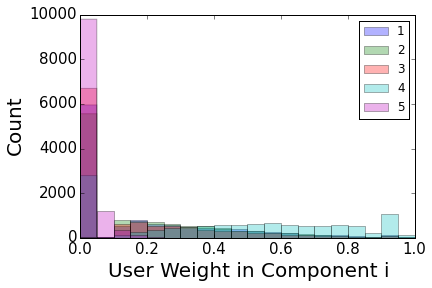

In [19]:
plt.figure()
for i in range(5):
    plt.hist(transformed[:, i], alpha=0.3, label=str(i+1),
            range=(0,1), bins=20)
plt.xlabel("User Weight in Component i", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

# Inspect the first component

(2624,)
Percentiles of the components:
[  2.00001300e-01   2.00002538e-01   2.00002780e-01   2.00002995e-01
   2.00003197e-01   2.00003455e-01   2.00003630e-01   2.00003870e-01
   2.00004052e-01   2.00004332e-01   2.00004533e-01   2.00004750e-01
   2.00004949e-01   2.00005260e-01   2.00005550e-01   2.00005770e-01
   2.00006029e-01   2.00006295e-01   2.00006526e-01   2.00006741e-01
   2.00007012e-01   2.00007282e-01   2.00007658e-01   2.00007918e-01
   2.00008103e-01   2.00008389e-01   2.00008653e-01   2.00008960e-01
   2.00009163e-01   2.00009456e-01   2.00009795e-01   2.00010088e-01
   2.00010492e-01   2.00010904e-01   2.00011419e-01   2.00011957e-01
   2.00012319e-01   2.00012740e-01   2.00013259e-01   2.00013803e-01
   2.00014418e-01   2.00015041e-01   2.00015772e-01   2.00016729e-01
   2.00018167e-01   2.00020291e-01   2.00029430e-01   2.00276264e-01
   2.00491124e-01   2.00697308e-01   2.00881980e-01   2.01004010e-01
   2.01117467e-01   2.01241621e-01   2.01379932e-01   2.01519783

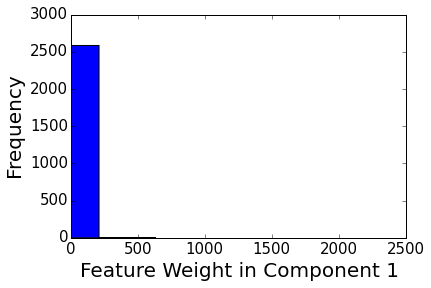

In [20]:
c1 = lda.components_[0, :]
print c1.shape

print "Percentiles of the components:"
print np.percentile(c1, np.arange(0,100,1))

plt.figure()
plt.hist(c1)
plt.xlabel("Feature Weight in Component 1", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()



# What do the values mean in the components?


In [21]:
c1_indices = np.where(c1 > np.percentile(c1, 99))[0]

#c1_indices = np.array(sorted(c1_indices, key= lambda x: c1[x], reverse=True))


top_c1_df = pd.DataFrame({'Component': profile_categorical_df.columns.values[c1_indices],
                         'Weight': c1[c1_indices]})

top_c1_df.sort_values('Weight', inplace=True, ascending=False)

top_c1_df.head(n=10)

,Component,Weight
26,status_single,2081.561689
16,orientation_straight,1666.605022
5,drugs_never,1530.587255
20,sex_m,1406.335820
4,drinks_socially,1122.861058
1,body_type_average,913.866062
24,speaks_english,873.462183
21,smokes_no,812.762851
2,diet_mostly anything,791.828282
19,sex_f,697.682041


Fascinating! The most important weight in this topic is the Pisces fine and it's something fun to think about!

Gov't, PhD, space camp and student follow closely on the heels of this.

So how many folks are high in this component?

(11504,)
Percentiles of user weights in this space:
[ 0.01184528  0.01194316  0.01197422  0.0119979   0.01201885  0.01204032
  0.01206873  0.0121082   0.01215249  0.01233115  0.0126735   0.01269386
  0.01271442  0.01273226  0.01275096  0.01277064  0.01278832  0.01280854
  0.01283221  0.01286037  0.01288763  0.01292772  0.01307383  0.01351267
  0.01353751  0.01355662  0.01357813  0.01359811  0.01361656  0.01364143
  0.01366441  0.01369847  0.01374056  0.01379619  0.01391706  0.01446921
  0.01450303  0.01453191  0.01456579  0.01459452  0.01462834  0.01467265
  0.01474057  0.01506291  0.01561409  0.01566608  0.01574274  0.01585477
  0.01690727  0.0170642   0.01842872  0.0202101   0.10170128  0.1184898
  0.12869751  0.13869976  0.14542463  0.15375706  0.16126406  0.16778516
  0.17468611  0.18233545  0.18979407  0.1972649   0.20621033  0.21514241
  0.22392732  0.23281226  0.2415518   0.25254678  0.26366998  0.27376399
  0.28488135  0.29362087  0.3034856   0.3161402   0.32797706  0.34277303


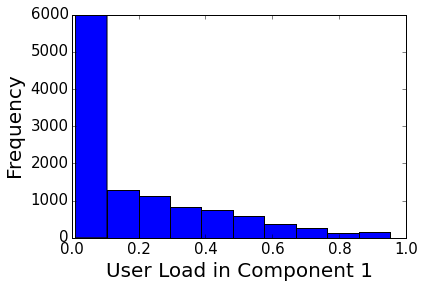

In [22]:
t1 = transformed[:, 0]
print t1.shape


print "Percentiles of user weights in this space:"
print np.percentile(t1, np.arange(0,100,1))


plt.figure()
plt.hist(t1)
plt.xlabel("User Load in Component 1", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()


what users are highest in component 1?

In [23]:
tmp_profile_df = profile_df.copy()

tmp_profile_df.insert(0, "User Load in Component 1", t1)

tmp_profile_df.sort_values('User Load in Component 1', inplace=True, ascending=False)

tmp_profile_df.head()

,User Load in Component 1,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
26304,0.952366,28,a little extra,mostly halal,not at all,never,working on college/university,in michigan for the summer. let the good times...,"i'm a flight attendant, while going back to sc...",a lot of things. hit me up if you really want ...,"my laugh, smile, and sense of humor. i most of...","books; the hakawati, destiny disrupted, a retu...","the ability to taste<br />\nlove, in all it's ...","death, and how cool it would be to jump throug...","working :( but, my work involves flying somewh...",i don't know what i'm doing. never have. while...,... you like sufi artistic types.<br />\n... y...,black,64.0,20000,transportation,2012-06-25-01-58,"berkeley, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,islam and very serious about it,f,capricorn and it&rsquo;s fun to think about,no,"english (fluently), arabic (poorly), urdu (poo...",single
26751,0.952351,25,a little extra,anything,socially,never,dropped out of college/university,ask and i will tell u :-),trying to find out what im meant to do,listening and sports and being a good friend,my hair,to much to write down but if u ask ill tell u,"is love, food, friends, movies, tv and weed :-)",about the future,at the movies and kickin it with the homies or...,iono,u wanna chat or get to no me,hispanic / latin,71.0,20000,other,2012-06-22-08-43,"hayward, california","doesn&rsquo;t have kids, but might want them",straight,has dogs,catholicism but not too serious about it,m,leo and it&rsquo;s fun to think about,sometimes,"english (fluently), spanish (okay)",single
39567,0.952339,27,a little extra,mostly anything,socially,sometimes,dropped out of high school,"im a goofy , horny , kind harted , honest man ...",nuthin so far just chillin for now,"massages , talking to people , acting like a d...",u tell me . ? .,im not a reader and i have a lot of favorites ...,"famly , food , woter , air . thats all i need ...",life &amp; death mostly life tho,doing whatever .,i think about boobs alot,u wont .,other,72.0,20000,unemployed,2012-06-30-16-06,"rodeo, california","doesn&rsquo;t have kids, but might want them",straight,has dogs and has cats,atheism but not too serious about it,m,leo and it&rsquo;s fun to think about,trying to quit,english (fluently),single
21954,0.952265,40,average,anything,often,never,graduated from two-year college,"love wine &amp; beer, music, hanging out, movi...",enjoying it,giving advise,tall,"love movies, music and food",NaN,NaN,in bed watching a movie,i like shaved guys,u wanna go wine tasting,white,75.0,70000,medicine / health,2012-05-24-19-59,"vallejo, california","doesn&rsquo;t have kids, but might want them",gay,has dogs and has cats,catholicism but not too serious about it,m,aquarius but it doesn&rsquo;t matter,no,english,single
10059,0.952241,51,a little extra,anything,rarely,never,graduated from high school,"i'm basically a very down to earth, even tempe...",NaN,NaN,NaN,NaN,NaN,NaN,home,NaN,you're a decent guy who wants friendship or th...,white,65.0,20000,other,2012-03-29-15-03,"san francisco, california",doesn&rsquo;t want kids,gay,likes dogs and likes cats,christianity,m,gemini and it&rsquo;s fun to think about,yes,english,single


# What do components mean?

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html



That's it for now.

Go have fun! And let us know how we can help!